### Импорт необходимых библиотек

In [184]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score

In [100]:
# !pip install vecstack
from vecstack import stacking

In [227]:
from sklearn.neural_network import MLPClassifier

In [230]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

from torch.utils.data import DataLoader

import torchvision.models as torch_models

from torchmetrics.classification import BinaryF1Score

In [5]:
from collections import namedtuple
from tqdm.notebook import tqdm
import sys

In [68]:
import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FitFailedWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


In [7]:
import random
import os

def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEEtorchmetricsD"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed = 123
seed_everything(seed)

### Подгрузка данных

In [8]:
og_transform = transforms.Compose([transforms.Resize((224, 224)),
                                   transforms.ToTensor()])

In [9]:
train_dataset = datasets.ImageFolder('./apples/train', 
                                     transform=og_transform)
test_dataset = datasets.ImageFolder('./apples/test', 
                                    transform=og_transform)


In [10]:
len(train_dataset), len(test_dataset)

(4035, 996)

0 - свежее <br>
1 - порченное

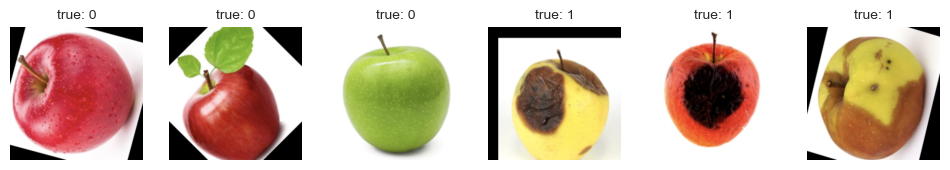

In [223]:
images_num = 6

assert images_num <= 8

fig, ax = plt.subplots(1, images_num, figsize=(12,8))

image_indices = [random.randint(0, len(train_dataset)) for _ in range(images_num)]

for i, ind in enumerate(image_indices):
    image, label = train_dataset[ind]
    ax[i].imshow(image.view(3, -1).T.reshape((224, 224, 3)).numpy())
    ax[i].axis('off')
    ax[i].set_title(f"true: {label}", fontsize=10)

## Классические алгоритмы машинного обучения

Создадим функцию, которая генерирует по каждому каналу трёхканального тензора изображения статистические признаки - среднее арифметическое, стандартное отклонение, коэффициент вариации, децили, размах.

In [13]:
def create_statistical_features(dataset):
    
    features_list = []
    target_list = []

    n = len(dataset)
    
    with tqdm(total=n) as prbar:
    
        for i in range(n):
            
            image, target = dataset[i]
            
            target_list.append(target)
            
            RGB_array = image.view(3, -1).numpy()
            mean_feature = RGB_array.mean(axis=1)
            std_feature = RGB_array.std(axis=1)
            cv = std_feature / mean_feature
            deciles = np.quantile(RGB_array, np.arange(0, 1.1, 0.1).tolist(), axis=1)
            range_feature = deciles[-1] - deciles[0]
            all_features_list = mean_feature.tolist() + std_feature.tolist() + cv.tolist() + deciles.flatten().tolist() + range_feature.tolist()
            
            features_list.append(all_features_list)
            
            prbar.update(1)
        
        features_df = pd.DataFrame(data=features_list)
        target_series = pd.Series(target_list)
    
    return features_df, target_series


Применим к обучающей и тестовой выборкам.

In [14]:
train_features_df, train_target_series = create_statistical_features(train_dataset)

  0%|          | 0/4035 [00:00<?, ?it/s]

In [15]:
test_features_df, test_target_series = create_statistical_features(test_dataset)

  0%|          | 0/996 [00:00<?, ?it/s]

Приступим к выбору и обучению моделей.

In [26]:
best_thresholds = {}

#### Logistic Regression

In [16]:
lr = LogisticRegression(solver='saga')

In [17]:
lr_params = {'penalty': ('l1', 'l2', 'elasticnet'),
             'C': np.arange(0.1, 5, 0.2)}
lr_gs = GridSearchCV(lr, lr_params, n_jobs=-1, scoring='accuracy')

In [18]:
lr_gs.fit(train_features_df, train_target_series)

GridSearchCV(estimator=LogisticRegression(solver='saga'), n_jobs=-1,
             param_grid={'C': array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5,
       2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.3, 4.5, 4.7, 4.9]),
                         'penalty': ('l1', 'l2', 'elasticnet')},
             scoring='accuracy')

In [19]:
lr_best_params = lr_gs.best_params_
print(lr_best_params)

{'C': 1.9000000000000004, 'penalty': 'l1'}


In [21]:
lr = LogisticRegression(solver='saga', **lr_best_params)
lr.fit(train_features_df, train_target_series)

LogisticRegression(C=1.9000000000000004, penalty='l1', solver='saga')

In [22]:
accuracy_score(lr.predict(test_features_df), test_target_series)

0.7981927710843374

In [23]:
f1_score(lr.predict(test_features_df), test_target_series)

0.8406026962727994

In [24]:
lr_scores_list = []
thresholds = np.arange(0.3, 0.7, 0.01)

for thr in thresholds:
    preds = (lr.predict_proba(test_features_df)[:, 1] > thr).astype(float)
    lr_scores_list.append([accuracy_score(preds, test_target_series), f1_score(preds, test_target_series)])

lr_scores_df = pd.DataFrame(data=lr_scores_list, 
                            index=thresholds, 
                            columns=['Accuracy', 'F1'])

In [27]:
best_thr = lr_scores_df['Accuracy'].nlargest(1).index.tolist()[0]
best_thresholds[lr] = best_thr

#### Support Vector Machines

In [28]:
svc = SVC(probability=True)

In [29]:
svc_params = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
              'C': np.arange(0.1, 5, 0.2)}
svc_gs = GridSearchCV(svc, svc_params, n_jobs=-1, scoring='accuracy')

In [30]:
svc_gs.fit(train_features_df, train_target_series)

GridSearchCV(estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5,
       2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.3, 4.5, 4.7, 4.9]),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             scoring='accuracy')

In [31]:
svc_best_params = svc_gs.best_params_
print(svc_best_params)

{'C': 4.9, 'kernel': 'poly'}


In [32]:
svc = SVC(probability=True, **svc_best_params)
svc.fit(train_features_df, train_target_series)

SVC(C=4.9, kernel='poly', probability=True)

In [33]:
accuracy_score(svc.predict(test_features_df), test_target_series)

0.9096385542168675

In [34]:
f1_score(svc.predict(test_features_df), test_target_series)

0.9265905383360523

In [35]:
svm_scores_list = []
thresholds = np.arange(0.3, 0.7, 0.01)

for thr in thresholds:
    preds = (svc.predict_proba(test_features_df)[:, 1] > thr).astype(float)
    svm_scores_list.append([accuracy_score(preds, test_target_series), f1_score(preds, test_target_series)])

svm_scores_df = pd.DataFrame(data=svm_scores_list, 
                             index=thresholds, 
                             columns=['Accuracy', 'F1'])

In [36]:
best_thr = svm_scores_df['Accuracy'].nlargest(1).index.tolist()[0]
best_thresholds[svc] = best_thr

#### K-Nearest Neighbors

In [37]:
knn = KNeighborsClassifier()

In [38]:
knn_params = {'weights': ('uniform', 'distance'),
              'n_neighbors': list(range(1, 30)),
              'p': [1, 2]}
knn_gs = GridSearchCV(knn, knn_params, n_jobs=-1, scoring='accuracy')

In [39]:
knn_gs.fit(train_features_df, train_target_series)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29],
                         'p': [1, 2], 'weights': ('uniform', 'distance')},
             scoring='accuracy')

In [40]:
knn_best_params = knn_gs.best_params_
print(knn_best_params)

{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}


In [41]:
knn = KNeighborsClassifier(**knn_best_params)
knn.fit(train_features_df, train_target_series)

KNeighborsClassifier(n_neighbors=1, p=1)

In [42]:
accuracy_score(knn.predict(test_features_df), test_target_series)

0.9769076305220884

In [43]:
f1_score(knn.predict(test_features_df), test_target_series)

0.9807531380753137

In [44]:
knn_scores_list = []
thresholds = np.arange(0.3, 0.7, 0.01)

for thr in thresholds:
    preds = (knn.predict_proba(test_features_df)[:, 1] > thr).astype(float)
    knn_scores_list.append([accuracy_score(preds, test_target_series), f1_score(preds, test_target_series)])

knn_scores_df = pd.DataFrame(data=knn_scores_list, 
                             index=thresholds, 
                             columns=['Accuracy', 'F1'])

In [45]:
best_thr = knn_scores_df['Accuracy'].nlargest(1).index.tolist()[0]
best_thresholds[knn] = best_thr

#### Random Forest

In [46]:
rfc = RandomForestClassifier(n_estimators=1000)

In [47]:
rfc_params = {'max_depth': list(range(1, 14, 4)) + [None],
              'min_samples_leaf': list(range(1, 5)),
              'max_features': ('sqrt', 'log2')}
rfc_gs = GridSearchCV(rfc, rfc_params, n_jobs=-1, scoring='accuracy')

In [48]:
rfc_gs.fit(train_features_df, train_target_series)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=1000), n_jobs=-1,
             param_grid={'max_depth': [1, 5, 9, 13, None],
                         'max_features': ('sqrt', 'log2'),
                         'min_samples_leaf': [1, 2, 3, 4]},
             scoring='accuracy')

In [49]:
rfc_best_params = rfc_gs.best_params_
print(rfc_best_params)

{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1}


In [50]:
rfc = RandomForestClassifier(n_estimators=1000, **rfc_best_params)
rfc.fit(train_features_df, train_target_series)

RandomForestClassifier(n_estimators=1000)

In [51]:
accuracy_score(rfc.predict(test_features_df), test_target_series)

0.9738955823293173

In [52]:
f1_score(rfc.predict(test_features_df), test_target_series)

0.978369384359401

In [53]:
rfc_scores_list = []
thresholds = np.arange(0.3, 0.7, 0.01)

for thr in thresholds:
    preds = (rfc.predict_proba(test_features_df)[:, 1] > thr).astype(float)
    rfc_scores_list.append([accuracy_score(preds, test_target_series), f1_score(preds, test_target_series)])

rfc_scores_df = pd.DataFrame(data=rfc_scores_list, 
                             index=thresholds, 
                             columns=['Accuracy', 'F1'])

In [54]:
best_thr = rfc_scores_df['Accuracy'].nlargest(1).index.tolist()[0]
best_thresholds[rfc] = best_thr

#### Catboost

In [55]:
catboost = CatBoostClassifier(custom_metric='Accuracy', eval_metric='Accuracy', verbose=0)

In [56]:
grid = {"l2_leaf_reg": [1, 2, 3, 4, 5, 6, 7, 8, 9],
        "depth": [4, 5, 6, 7, 8, 9, 10]}

grid_search_result = catboost.grid_search(grid,
                                          X=train_features_df,
                                          y=train_target_series,
                                          plot=False,
                                          stratified=True)


bestTest = 0.9690210657
bestIteration = 848

0:	loss: 0.9690211	best: 0.9690211 (0)	total: 3.9s	remaining: 4m 1s

bestTest = 0.9714993804
bestIteration = 632

1:	loss: 0.9714994	best: 0.9714994 (1)	total: 7.54s	remaining: 3m 50s

bestTest = 0.9714993804
bestIteration = 949

2:	loss: 0.9714994	best: 0.9714994 (1)	total: 11.2s	remaining: 3m 44s

bestTest = 0.9739776952
bestIteration = 983

3:	loss: 0.9739777	best: 0.9739777 (3)	total: 15.2s	remaining: 3m 44s

bestTest = 0.970260223
bestIteration = 799

4:	loss: 0.9702602	best: 0.9739777 (3)	total: 19.5s	remaining: 3m 46s

bestTest = 0.970260223
bestIteration = 835

5:	loss: 0.9702602	best: 0.9739777 (3)	total: 24s	remaining: 3m 48s

bestTest = 0.9727385378
bestIteration = 804

6:	loss: 0.9727385	best: 0.9739777 (3)	total: 29.2s	remaining: 3m 53s

bestTest = 0.970260223
bestIteration = 994

7:	loss: 0.9702602	best: 0.9739777 (3)	total: 34.1s	remaining: 3m 54s

bestTest = 0.9727385378
bestIteration = 914

8:	loss: 0.9727385	best: 0.973977

In [57]:
catboost_best_params = grid_search_result['params']
print(catboost_best_params)

{'depth': 10, 'l2_leaf_reg': 2}


In [58]:
catboost = CatBoostClassifier(custom_metric='Accuracy', eval_metric='Accuracy', verbose=0, **catboost_best_params)

In [60]:
catboost.fit(X=train_features_df,
             y=train_target_series)

In [61]:
accuracy_score(catboost.predict(test_features_df), test_target_series)

0.9759036144578314

In [62]:
f1_score(catboost.predict(test_features_df), test_target_series)

0.9799999999999999

In [63]:
catboost_scores_list = []
thresholds = np.arange(0.3, 0.7, 0.01)

for thr in thresholds:
    preds = (catboost.predict_proba(test_features_df)[:, 1] > thr).astype(float)
    catboost_scores_list.append([accuracy_score(preds, test_target_series), f1_score(preds, test_target_series)])

catboost_scores_df = pd.DataFrame(data=rfc_scores_list, 
                                  index=thresholds, 
                                  columns=['Accuracy', 'F1'])

In [64]:
best_thr = catboost_scores_df['Accuracy'].nlargest(1).index.tolist()[0]
best_thresholds['Catboost'] = best_thr

Сравним обученные модели.

In [65]:
all_metrics_list = []
models = [lr, svc, knn, rfc, catboost]

for clf in models:
    if clf == catboost:
        thr = best_thresholds['Catboost']
    else:
        thr = best_thresholds[clf]
    preds = (clf.predict_proba(test_features_df)[:, 1] > thr).astype(float)
    clf_metrics_list = [accuracy_score(preds, test_target_series), f1_score(preds, test_target_series)]
    all_metrics_list.append(clf_metrics_list)

compare_df = pd.DataFrame(data=all_metrics_list, 
                          index=['Logistic Regression', 'SVM', 'K-Nearest Neighbors', 'Random Forest', 'Catboost'], 
                          columns=['Accuracy', 'F1'])

Наиболее высокое качество показывают алгоритмы K-Nearest Neighbors, Random Forest и Catboost.

In [66]:
compare_df

,Accuracy,F1
Logistic Regression,0.819277,0.851974
SVM,0.920683,0.934872
K-Nearest Neighbors,0.976908,0.980753
Random Forest,0.973896,0.978441
Catboost,0.975904,0.980000


Попробуем сделать ансамбль алгоритмов с помощью стэкинга.

In [69]:
S_train, S_test = stacking(models,              
                           train_features_df, train_target_series, test_features_df,
                           regression=False,
                           mode='oof_pred_bag',
                           needs_proba=False,
                           save_dir=None,
                           metric=accuracy_score,
                           n_folds=3,
                           stratified=True,
                           shuffle=True,
                           random_state=seed,
                           verbose=0)

In [71]:
mlp = MLPClassifier(max_iter=150, 
                    activation='relu', 
                    learning_rate='adaptive')

In [74]:
params = {'hidden_layer_sizes': [(4, 4, 4), 
                                 (8, 8, 8), 
                                 (16, 16, 16),
                                 (32, 32, 32),
                                 (8, 4, 8), 
                                 (16, 8, 16), 
                                 (32, 8, 32),
                                 (4, 8, 16, 8, 4)
                                ]
         }
mlp_gs = GridSearchCV(mlp, params, n_jobs=-1, scoring='accuracy')

In [76]:
mlp_gs.fit(S_train, train_target_series)

GridSearchCV(estimator=MLPClassifier(learning_rate='adaptive', max_iter=150),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(4, 4, 4), (8, 8, 8),
                                                (16, 16, 16), (32, 32, 32),
                                                (8, 4, 8), (16, 8, 16),
                                                (32, 8, 32),
                                                (4, 8, 16, 8, 4)]},
             scoring='accuracy')

In [79]:
mlp_params = mlp_gs.best_params_
print(mlp_params)

{'hidden_layer_sizes': (32, 8, 32)}


In [80]:
mlp = MLPClassifier(max_iter=150, 
                    activation='relu', 
                    learning_rate='adaptive',
                    **mlp_params)

In [82]:
mlp.fit(S_train, train_target_series)

MLPClassifier(hidden_layer_sizes=(32, 8, 32), learning_rate='adaptive',
              max_iter=150)

In [83]:
accuracy_score(mlp.predict(S_test), test_target_series)

0.9799196787148594

In [84]:
f1_score(mlp.predict(S_test), test_target_series)

0.9831649831649832

In [86]:
mlp_scores_list = []
thresholds = np.arange(0.3, 0.7, 0.01)

for thr in thresholds:
    preds = (mlp.predict_proba(S_test)[:, 1] > thr).astype(float)
    mlp_scores_list.append([accuracy_score(preds, test_target_series), f1_score(preds, test_target_series)])

mlp_scores_df = pd.DataFrame(data=mlp_scores_list, 
                             index=thresholds, 
                             columns=['Accuracy', 'F1'])

In [87]:
best_thr = mlp_scores_df['Accuracy'].nlargest(1).index.tolist()[0]
best_thresholds[mlp] = best_thr

In [95]:
preds = (mlp.predict_proba(S_test)[:, 1] > best_thresholds[mlp]).astype(float)
compare_df.loc['Ensemble Classifier'] = (accuracy_score(preds, test_target_series), f1_score(preds, test_target_series))

С помощью стэкинга удалось увеличить качество модели.

In [101]:
compare_df

,Accuracy,F1
Logistic Regression,0.819277,0.851974
SVM,0.920683,0.934872
K-Nearest Neighbors,0.976908,0.980753
Random Forest,0.973896,0.978441
Catboost,0.975904,0.980000
Ensemble Classifier,0.979920,0.983165


Классические алгоритмы позволяют добиться высокого качества даже без использования глубинного обучения. Можно ли улучшить результат с помощью нейронных сетей?

## Нейронные сети

In [155]:
def train_epoch(model,
                train_dataloader,
                optimizer,
                criterion):
    
    model.train()
    total_loss = 0
    num_batches = 0
    correct = 0
    total = 0

    with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
        for images, labels in train_dataloader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            _, pred_classes = torch.max(outputs, 1)
            batch_accuracy = (pred_classes == labels).float().mean().item() * 100
            correct += (pred_classes == labels).sum().item()
            total += labels.size(0)
            
            total_loss += loss.item()
            num_batches += 1
            
            prbar.set_description(f"Loss: {round(loss.item(), 4)}. Accuracy: {round(batch_accuracy, 4)}%")
            prbar.update(1)
            
    epoch_loss = total_loss/num_batches
    epoch_accuracy = 100*correct/total
    
    prbar.set_description(f"Loss: {round(epoch_loss, 4)}. Accuracy: {round(epoch_accuracy, 4)}%")
    prbar.update(1)        
    
    metrics = {'loss': round(epoch_loss, 4),
               'accuracy': round(epoch_accuracy, 4)}
    
    return metrics


In [226]:
def validate(model,
             criterion,
             dataloader):
    
    model = model.eval()
    total_loss = 0
    num_batches = 0
    
    correct = 0
    total = 0
    
    preds = []
    trues = []
    
    for images, labels in dataloader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        _, pred_classes = torch.max(outputs, 1)
        batch_accuracy = (pred_classes == labels).float().mean().item() * 100
        
        correct += (pred_classes == labels).sum().item()
        total += labels.size(0)
        
        preds += pred_classes.tolist()
        trues += labels.tolist()
        
        total_loss += loss.item()
        num_batches += 1
    
    epoch_loss = total_loss/num_batches
    epoch_accuracy = 100*correct/total
    epoch_f1_score = 100*BinaryF1Score()(torch.tensor(preds), torch.tensor(trues)).item()
    
    print(f"Loss: {round(epoch_loss, 4)}. Accuracy: {round(epoch_accuracy, 4)}%. F1 score: {round(epoch_f1_score, 4)}%")
    
    metrics = {'loss': round(epoch_loss, 4),
               'accuracy': round(epoch_accuracy, 4),
               'F1 score': round(epoch_f1_score, 4)}
    
    return metrics


In [200]:
def fit(model,
        optimizer,
        scheduler,
        criterion,
        epochs,
        train_dataloader,
        test_dataloader):
    
    LossInfo = namedtuple('LossInfo', ['train_epoch_losses', 'train_epoch_accuracy', 'test_epoch_losses', 'test_epoch_accuracy'])

    epoch_train_losses = []
    epoch_train_accuracy = []

    epoch_test_losses = []
    epoch_test_accuracy = []
    
    for epoch in range(1, epochs+1):
        print(f"Train Epoch: {epoch}")
        train_metrics = train_epoch(model=model,
                                    train_dataloader=train_dataloader,
                                    optimizer=optimizer,
                                    criterion=criterion)
        epoch_train_losses.append(train_metrics['loss'])
        epoch_train_accuracy.append(train_metrics['accuracy'])
        
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(model=model,
                                          criterion=criterion,
                                          dataloader=test_dataloader)
        epoch_test_losses.append(validation_metrics['loss'])
        epoch_test_accuracy.append(validation_metrics['accuracy'])
        
        if validation_metrics['accuracy'] > 99.99:
            break
        if (len(epoch_test_accuracy) > 2 and (epoch_test_accuracy[-3] > epoch_test_accuracy[-2] 
                                             and epoch_test_accuracy[-2] > epoch_test_accuracy[-1])):
            break
        print()
        print()
        scheduler.step()
    
    return LossInfo(epoch_train_losses, epoch_train_accuracy, epoch_test_losses, epoch_test_accuracy)


In [224]:
def plot_metrics_graph(info, model='Model', show_numbers=False):
    
    x = list(range(len(info.test_epoch_accuracy)))
    x_ticks = list(range(1, len(info.test_epoch_accuracy)+1))
    
    fig, ax = plt.subplots(1, 2, figsize=(16,6))
    
    ax[0].grid()
    ax[0].plot(info.train_epoch_accuracy, color='blue', label='train')
    ax[0].plot(info.test_epoch_accuracy, color='red', label='test')
    ax[0].legend()
    ax[0].set_title('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    if show_numbers:
        for index in x:
            ax[0].text(x[index], info.test_epoch_accuracy[index], info.test_epoch_accuracy[index], size=10)
    ax[0].set_xticks(x, x_ticks, size=10)

    ax[1].grid()
    ax[1].plot(info.train_epoch_losses, color='blue', label='train')
    ax[1].plot(info.test_epoch_losses, color='red', label='test')
    ax[1].legend()
    ax[1].set_title('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    if show_numbers:
        for index in x:
            ax[1].text(x[index], info.test_epoch_losses[index], info.test_epoch_losses[index], size=10)
    ax[1].set_xticks(x, x_ticks, size=10)
    
    fig.suptitle(model, fontsize=16)

In [202]:
def show_model_predictions(model, images_num, dataloader):
    
    assert images_num <= 32

    fig, ax = plt.subplots(1, images_num, figsize=(12,8))

    for images, labels in dataloader:
        _, preds = torch.max(model(images), 1)
        for i in range(images_num):
            ax[i].imshow(images[i].view(3, -1).T.reshape((224, 224, 3)).numpy())
            ax[i].axis('off')
            ax[i].set_title(f"true: {labels[i].item()}; pred: {preds[i].item()}", fontsize=10)
        break

In [203]:
def count_params_num(model):
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in trainable_params])

In [204]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=8,
                              shuffle=True)
test_dataloader = DataLoader(test_dataset,
                             batch_size=32,
                             shuffle=True)

Попробуем взять одну из популярных архитектур, ShuffleNet, её предобученную версию и дообучить на датасете. Предпочтение отдаётся именно ShuffleNet, так как она показала достаточно высокую точность на ImageNet, обладая относительно небольшим числом параметров.

### ShuffleNet

In [167]:
model_shufflenet = torch_models.shufflenet_v2_x1_5(weights='DEFAULT')
optimizer = optim.Adam(model_shufflenet.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=5)
criterion = nn.CrossEntropyLoss()

In [169]:
count_params_num(model_shufflenet)

3503624

In [171]:
info = fit(model=model_shufflenet,
           optimizer=optimizer,
           scheduler=scheduler,
           criterion=criterion,
           epochs=10,
           train_dataloader=train_dataloader,
           test_dataloader=test_dataloader)

Train Epoch: 1


  0%|          | 0/505 [00:00<?, ?it/s]

Validation Epoch: 1
Loss: 0.0564. Accuracy: 98.494%


Train Epoch: 2


  0%|          | 0/505 [00:00<?, ?it/s]

Validation Epoch: 2
Loss: 0.0287. Accuracy: 99.8996%


Train Epoch: 3


  0%|          | 0/505 [00:00<?, ?it/s]

Validation Epoch: 3
Loss: 0.0056. Accuracy: 100.0%


In [211]:
_ = validate(model=model_shufflenet, 
             criterion=criterion, 
             dataloader=test_dataloader)

Loss: 0.0055. Accuracy: 100.0%. F1 score: 1.0


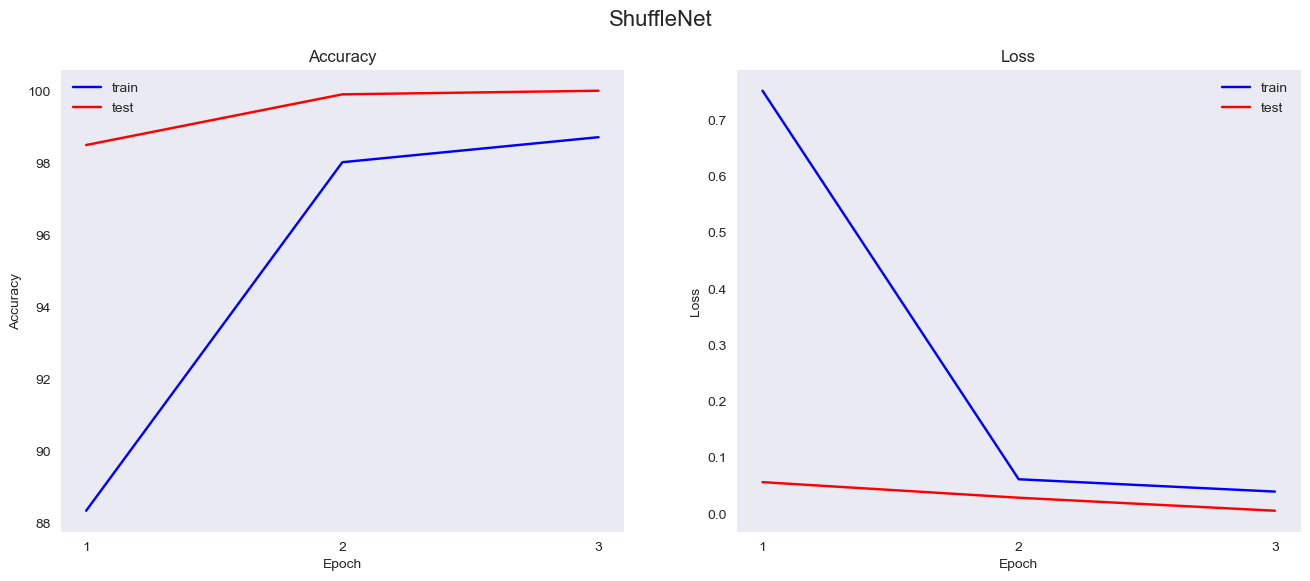

In [225]:
plot_metrics_graph(info, model='ShuffleNet')

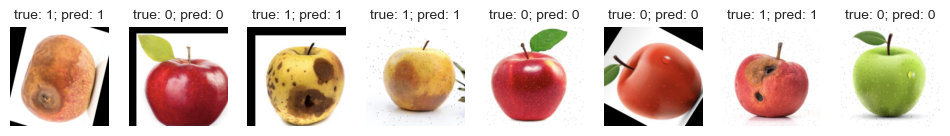

In [188]:
show_model_predictions(model_shufflenet, 
                       images_num=8, 
                       dataloader=test_dataloader)

С помощью архитектуры свёрточных нейронных сетей ShuffleNet удалось достичь 100% Accuracy и F1-Score на тестовой выборке.

In [229]:
torch.save(model_shufflenet.state_dict(), './model')